In [108]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import requests

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import numpy as np

!pip install missingno
import missingno as msno

np.random.seed(42)

# Predictive modeling with scikit-learn (Nov 21, 2024)

- Last week:
    - a crash course on clustering 
    - non-spatial: k-means
    - spatial: DBSCAN

## Reminder: clustering is an example of *unsupervised learning*

- Clustering tries to detect previously unknown structure in your input dataset
- Only requires the data set as input, no associated labels or prediction targets

## Today: an example of *supervised learning*


- **Key distinction**: requires a training data set as well as the desired solutions (called *labels*) as inputs to the algorithm
- Two main types:
    - **Classification**: samples belong to two or more classes and we want to learn from already labeled data how to predict the class of unlabeled data. 
    - **Regression**: predicting a continuous variable from a training dataset


<img src="imgs/classification-vs-regression.png" width=800></img>

## Examples:

- **Classification**: a spam filter to classify new emails as spam / not spam based on past examples
- **Regression**: predicting housing prices based on property characteristics

**-->walk through an end-to-end regression example to predict Philadelphia's housing prices** 

## Model-based learning

- Select a model that can represent the data 
- Use the training data to identify the best model parameters (by minimizing a *cost function*)
- Make predictions on new data — and hope that your model *generalizes* well to new data!


## Machine learning is really just an **optimization problem**

Given your training set of data, which model parameters best represent the observed data?

### 1. Choose a model

<img src="imgs/model-1.png" width=400></img>

### 2. The model has an associated cost function

The *cost function* measures the difference between the model's predictions and the observed data

<img src="imgs/model-2.png" width=450></img>

### 3. "Learn" the best model parameters

In scikit-learn, you will call the `fit()` method on your algorithm.

<img src="imgs/model-3.png" width=600></img>


## Recap: the steps involved

1. Wrangle and understand data. 
1. Select a model that would be best for your dataset.
1. Train the model on the training data — the learning algorithm searches for the best model parameters
1. Apply the model to new data to make predictions.

**Key goal: how we can do this in a way to ensure the model is as generalizable as possible?**

## What could go wrong?


<img src=https://media.giphy.com/media/nDxjSaLT9gFig/giphy.gif width=600></img>

### Mistake #1: "bad data"

Or: "garbage in, garbage out" 

**Common issues:**

- Not enough training data
- Training data isn't representative of the unseen data that you want to make predictions for
- Poor quality data — errors, missing data, outliers
- Poor features in the training set
    - You'll often hear the phrase *feature engineering* to describe the process of improving your input dataset 
    - Involves: feature selection, feature extraction, creating new features

### Mistake #2: "bad algorithm"

- Overfitting the training data (more on this shortly)
    - model performs well, too well in fact, on the training set, and does not generalize well
    - model is **too complex** for your training set
- Underfitting the training data
    - model is **not complex enough**
    - predictions will be inacurrate, but adding more model parameters (making it more complex) will help improve the accuracy

## Regularization: keeping it simple

- We can *regularize* our model to prevent the model from getting too complex and avoid overfitting
- Adds a penalty to the cost function that prevents parameters from getting too large
- Can effectively think of regularization as forcing some model parameters to be close, not quite, zero

<img src="imgs/regularization.png" width=600></img>

##  Key question: How do we know if a model will perform well on new data?

<img src="https://media.giphy.com/media/3ohhwjIjLLWBh4EQRW/giphy.gif" width=600></img>

**Note:** Crossing your fingers and hoping for the best is not the recommended strategy

## Option #1: a train/test split

- Split your data into two sets: the *training set* and the *test set*
- Train on the training set and test on the test set!
- The accuracy on the test set provides a measure of how well your model generalizes

Common to use 80% of data for your training set and 20% for your test set

- Still run the risk that you've selected the best model parameters for this **specific** training/test combination
- For example: 
    - Does the model work best on a 80/20 split, a 60/40 split, 70/30? How to decide the test/train split?
    - If you are using regularization, did your regularization strength parameter work only on this specific training set?

## Option #2: *k*-fold cross-validation

1. Break the data into a training set and test set
2. Split the training set into *k* subsets (or folds), holding out one subset as the test set
3. Run the learning algorithm on each combination of subsets, using the average of all of the runs to find the best fitting model parameters


 - For more information, see the [scikit-learn docs](https://scikit-learn.org/stable/modules/cross_validation.html).


<img src="imgs/crossval.png" width=600></img>

## Let's try out a simple example: does money make people happier?

We'll load data compiled from two data sources:
- The *Better Life Index* from the [OECD's website](https://stats.oecd.org/index.aspx?DataSetCode=BLI)
- GDP per capita from the [IMF's website](https://www.imf.org/external/pubs/ft/weo/2016/01/weodata/weorept.aspx?pr.x=32&pr.y=8&sy=2015&ey=2015&scsm=1&ssd=1&sort=country&ds=.&br=1&c=512,668,914,672,612,946,614,137,311,962,213,674,911,676,193,548,122,556,912,678,313,181,419,867,513,682,316,684,913,273,124,868,339,921,638,948,514,943,218,686,963,688,616,518,223,728,516,558,918,138,748,196,618,278,624,692,522,694,622,142,156,449,626,564,628,565,228,283,924,853,233,288,632,293,636,566,634,964,238,182,662,453,960,968,423,922,935,714,128,862,611,135,321,716,243,456,248,722,469,942,253,718,642,724,643,576,939,936,644,961,819,813,172,199,132,733,646,184,648,524,915,361,134,362,652,364,174,732,328,366,258,734,656,144,654,146,336,463,263,528,268,923,532,738,944,578,176,537,534,742,536,866,429,369,433,744,178,186,436,925,136,869,343,746,158,926,439,466,916,112,664,111,826,298,542,927,967,846,443,299,917,582,544,474,941,754,446,698,666&s=NGDPDPC&grp=0&a)

In [20]:
data = pd.read_csv("./data/gdp_vs_satisfaction.csv")
data.head()

,Country,life_satisfaction,gdp_per_capita
0,Australia,7.3,50961.87
1,Austria,7.1,43724.03
2,Belgium,6.9,40106.63
3,Brazil,6.4,8670.00
4,Canada,7.4,43331.96


### Make a quick plot

In [13]:
#!pip install --upgrade holoviews numpy
import hvplot.pandas

In [36]:
data.hvplot.scatter(
    x="gdp_per_capita",
    y="life_satisfaction",
    hover_cols=["Country"],
    ylim=(4, 9),
    xlim=(1e3, 1.1e5),
)

/Users/delmelle/miniforge3/lib/python3.10/site-packages/holoviews/core/util.py:1010: RuntimeWarning: invalid value encountered in cast
  arr = np.array(values)
/Users/delmelle/miniforge3/lib/python3.10/site-packages/holoviews/core/util.py:1010: RuntimeWarning: invalid value encountered in cast
  arr = np.array(values)


:Scatter   [gdp_per_capita]   (life_satisfaction,Country)

### There's a roughly linear trend here...let's start there

<img src="imgs/life-happy.png" width=600></img>

A simple model with only two parameters

Use the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model object from scikit-learn.

This is not *really* machine learning — it simply finds the [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) fit to the data.

In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
model = LinearRegression()
model

LinearRegression()

In [39]:
# Our input features (in this case we only have 1)
X = data['gdp_per_capita'].values
X = X[:, np.newaxis]

# The labels (values we are trying to predict)
y = data['life_satisfaction'].values

In [40]:
X.shape

(40, 1)

In [41]:
y.shape

(40,)

Watch out! Scikit-learn expects the features to be a 2D array with shape: `(number of observations, number of features)`. 

In this case, we are explicitly adding a second axis with the `np.newaxis` variable.

Now, fit the model using the `model.fit(X, y)` syntax. 

This will "train" our model, using an optimization algorithm to identify the bestfit parameters.

In [42]:
model.fit(X, y)

LinearRegression()

In [43]:
model.coef_

array([2.46904428e-05])

In [44]:
intercept = model.intercept_
slope = model.coef_[0]

print(f"bestfit intercept = {intercept:.2f}")
print(f"bestfit slope = {slope:.2e}")

bestfit intercept = 5.72
bestfit slope = 2.47e-05


### What's with the "_" at the end of variable names?

These represent "estimated" properties of the model — this is how scikit learn signals to the user that these attributes depend on the `fit()` function being called beforehand.

More info [here](https://scikit-learn.org/dev/developers/develop.html#estimated-attributes).

**Note:** In this case, our model is the same as ordinary least squares, and no actually optimization is performed since an exact solution exists.

### How good is the fit?

- Each scikit learn model has a built-in `score()` function that provides a score to evaluate the fit by.
- In the case of the linear model, the score is the R-squared coefficient of the fit

**Note:** you must call the `fit()` function before calling the `score()` function.

In [45]:
Rsq = model.score(X, y)
Rsq

0.519153782362894

### Let's plot the data and the predicted values

Use the `predict()` function to predict new values.

In [46]:
# The values we want to predict (ranging from our min to max GDP per capita)
gdp_pred = np.linspace(1e3, 1.1e5, 100)

# Sklearn needs the second axis!
X_pred = gdp_pred[:, np.newaxis]

y_pred = model.predict(X_pred)

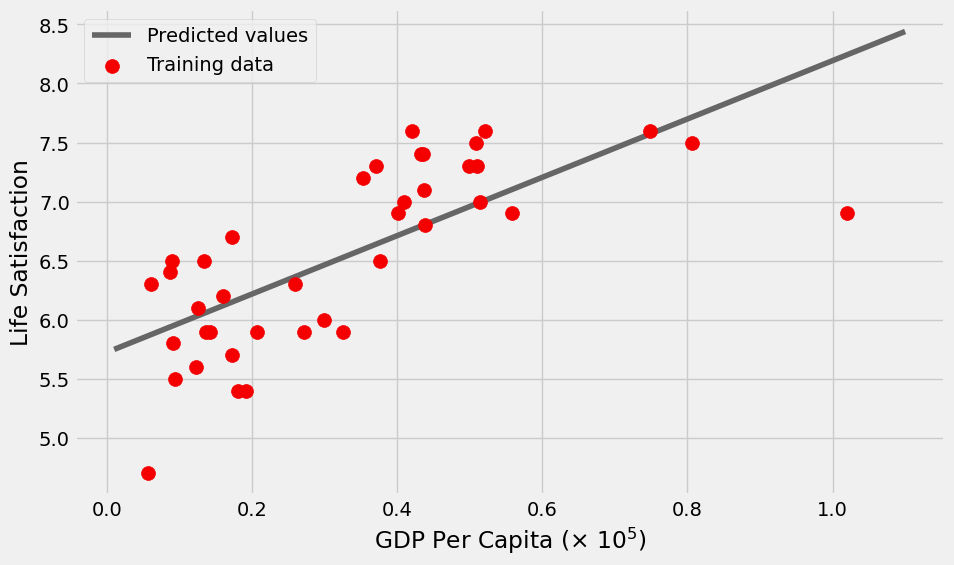

In [49]:
with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the predicted values
    ax.plot(X_pred / 1e5, y_pred, label="Predicted values", color="#666666")

    # Training data
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Training data",
        s=100,
        zorder=10,
        color="#f40000",
    )

    ax.legend()
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")

plt.show()

### Not bad....but what did we do wrong?

<img src=https://media.giphy.com/media/1Bh2zyW2yuBEalV0rO/giphy.gif width=500></img>

### Two Problems!

#### 1. We also fit and evaluated our model on the same training set!

#### 2. We didn't scale our input data features!

Scikit learn provides a utility function to split our input data:

In [50]:
from sklearn.model_selection import train_test_split

In [52]:
# I'll use a 70/30% split
train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

These are new DataFrame objects, with lengths determined by the split percentage:

In [53]:
print("size of full dataset = ", len(data))
print("size of training dataset = ", len(train_set))
print("size of test dataset = ", len(test_set))

size of full dataset =  40
size of training dataset =  28
size of test dataset =  12


Now, make our feature and label arrays:

In [54]:
# Features
X_train = train_set['gdp_per_capita'].values
X_train = X_train[:, np.newaxis]

X_test = test_set['gdp_per_capita'].values
X_test = X_test[:, np.newaxis]

# Labels
y_train = train_set['life_satisfaction'].values
y_test = test_set['life_satisfaction'].values

Use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the GDP per capita:

In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
scaler = StandardScaler()

In [57]:
# Scale the training features
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test features
X_test_scaled = scaler.fit_transform(X_test)

Now, let's fit on the *training set* and evaluate on the *test set*

In [58]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [59]:
model.score(X_test_scaled, y_test)

0.3595958514715957

**Unsurprisingly, our fit gets worst when we test on unseen data**

Our accuracy was artifically inflated the first time, since we trained and tested on the same data.

### Can we do better? Let's do some feature engineering...

We'll use scikit learn's [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to add new polynomial features from the GDP per capita.

In [60]:
from sklearn.preprocessing import PolynomialFeatures

#### Let's try up to degree 3 polynomials ($x^3$)

In [61]:
poly = PolynomialFeatures(degree=3)

### Now we have two transformations to make:

1. Scale our features
1. Create the polynomial features

In [62]:
# Training
X_train_scaled_poly = poly.fit_transform(scaler.fit_transform(X_train))

# Test
X_test_scaled_poly = poly.fit_transform(scaler.fit_transform(X_test))

In [63]:
X_train_scaled_poly.shape

(28, 4)

In [64]:
model.fit(X_train_scaled_poly, y_train)

LinearRegression()

In [65]:
model.score(X_test_scaled_poly, y_test)

0.5597457659851048

**The accuracy improved!**

### Pipelines: making multiple transformations *much* easier

We can turn our preprocessing steps into a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) object using the [`make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) function.

In [67]:
from sklearn.pipeline import make_pipeline

In [68]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3))

pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3))])

Individual steps can be accessed via their names in a dict-like fashion:

In [69]:
# Step 1
pipe['standardscaler']

StandardScaler()

In [70]:
# Step 2
pipe['polynomialfeatures']

PolynomialFeatures(degree=3)

Let's apply this pipeline to our predicted GDP values for our plot:

In [71]:
y_pred = model.predict(pipe.fit_transform(X_pred))

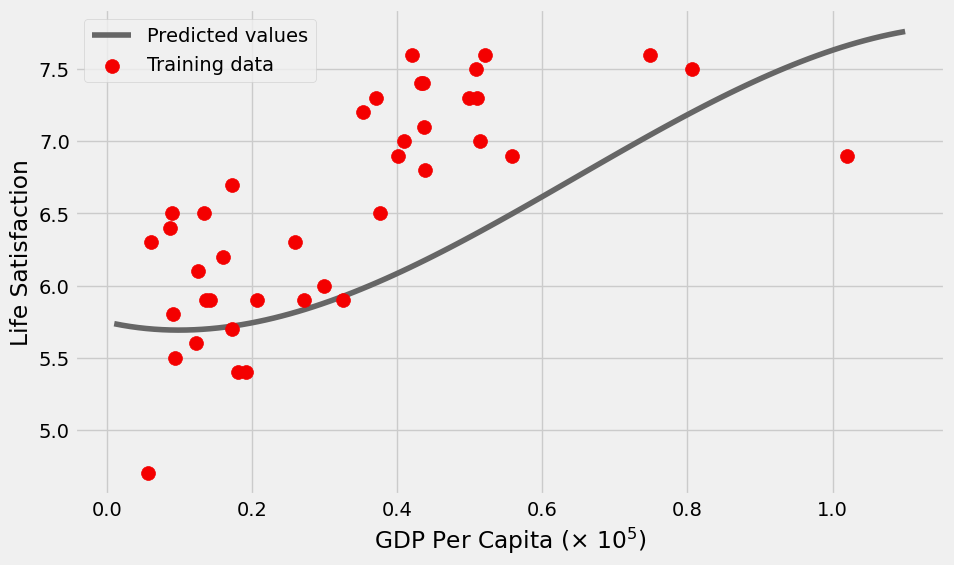

In [72]:
with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the predicted values
    y_pred = model.predict(pipe.fit_transform(X_pred))
    ax.plot(X_pred / 1e5 , y_pred, label="Predicted values", color="#666666")

    # Training data
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Training data",
        s=100,
        zorder=10,
        color="#f40000",
    )

    ax.legend()
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction");
    plt.show()

**The additional polynomial features introduced some curvature and improved the fit!**

### How about large polynomial degrees?

degree = 3
Training Score = 0.6458898101593082
Test Score = 0.5597457659851048

degree = 5
Training Score = 0.6846206186564372
Test Score = -3.94657525455514

degree = 10
Training Score = 0.8020213670053926
Test Score = -26330.208557019356



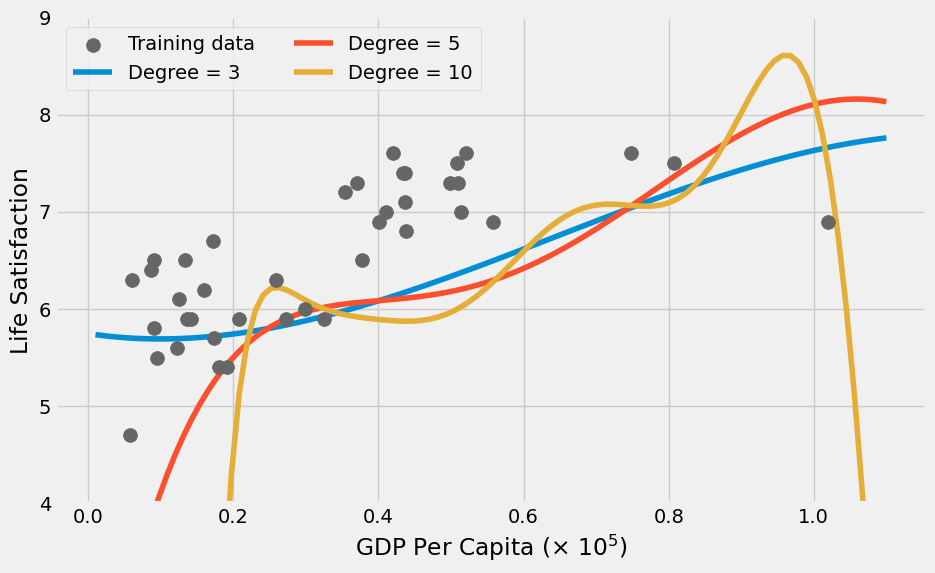

In [73]:
with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    # Original data set
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Training data",
        s=100,
        zorder=10,
        color="#666666",
    )
    
    # Plot the predicted values
    for degree in [3, 5, 10]:
        print(f"degree = {degree}")
        
        # Create out pipeline
        p = make_pipeline(StandardScaler(), PolynomialFeatures(degree=degree))
        
        # Fit the model on the training set
        model.fit(p.fit_transform(X_train), y_train)
        
        # Evaluate on the training set
        training_score = model.score(p.fit_transform(X_train), y_train)
        print(f"Training Score = {training_score}")
        
        # Evaluate on the test set
        test_score = model.score(p.fit_transform(X_test), y_test)
        print(f"Test Score = {test_score}")
        
        # Plot
        y_pred = model.predict(p.fit_transform(X_pred))
        ax.plot(X_pred / 1e5, y_pred, label=f"Degree = {degree}")
        
        print()

    ax.legend(ncol=2, loc=0)
    ax.set_ylim(4, 9)
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")
    plt.show();

### Overfitting alert!

As we increase the polynomial degree, two things happen:

1. Training accuracy goes way up 
1. Test accuracy goes way down
    
This is the classic case of overfitting — our model does not generalize well at all.

### Regularization to the rescue?

- The [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) adds regularization to the linear regression least squares model
- Parameter *alpha* determines the level of regularization
- Larger values of *alpha* mean stronger regularization — results in a "simpler" bestfit

**Remember, regularization penalizes large parameter values and complex fits**

Let's gain some intuition:

- Fix the polynomial degree to 3
- Try out alpha values of 0, 10, 100, and $10^5$
- Compare to linear fit (no polynomial features)


**Important**
- Baseline: linear model
    - This uses `LinearModel` and scales input features with `StandardScaler`
- Ridge regression: try multiple regularization strength values
    - Use a pipeline object to apply both a `StandardScaler` and `PolynomialFeatures(degree=3)` pre-processing to features

Set up a grid of GDP per capita points to make predictions for:

In [78]:
from sklearn.linear_model import Ridge

In [79]:
# The values we want to predict (ranging from our min to max GDP per capita)
gdp_pred = np.linspace(1e3, 1.1e5, 100)

# Sklearn needs the second axis!
X_pred = gdp_pred[:, np.newaxis]

In [80]:
# Create a pre-processing pipeline
# This scales and adds polynomial features up to degree = 3
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3))

# BASELINE: Setup and fit a linear model (with scaled features)
linear = LinearRegression()
scaler = StandardScaler()
linear.fit(scaler.fit_transform(X_train), y_train)


with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    ## Plot the data
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Data",
        s=100,
        zorder=10,
        color="#666666",
    )

    ## Evaluate the linear fit
    print("Linear fit")
    training_score = linear.score(scaler.fit_transform(X_train), y_train)
    print(f"Training Score = {training_score}")

    test_score = linear.score(scaler.fit_transform(X_test), y_test)
    print(f"Test Score = {test_score}")
    print()


    ## Plot the linear fit
    ax.plot(
        X_pred / 1e5,
        linear.predict(scaler.fit_transform(X_pred)),
        color="k",
        label="Linear fit",
    )

    ## Ridge regression: linear model with regularization 
    # Plot the predicted values for each alpha
    for alpha in [0, 10, 100, 1e5]:
        print(f"alpha = {alpha}")

        # Create out Ridge model with this alpha
        ridge = Ridge(alpha=alpha)

        # Fit the model on the training set
        # NOTE: Use the pipeline that includes polynomial features
        ridge.fit(pipe.fit_transform(X_train), y_train)

        # Evaluate on the training set
        training_score = ridge.score(pipe.fit_transform(X_train), y_train)
        print(f"Training Score = {training_score}")

        # Evaluate on the test set
        test_score = ridge.score(pipe.fit_transform(X_test), y_test)
        print(f"Test Score = {test_score}")

        # Plot the ridge results
        y_pred = ridge.predict(pipe.fit_transform(X_pred))
        ax.plot(X_pred / 1e5, y_pred, label=f"alpha = {alpha}")

        print()

    # Plot formatting
    ax.legend(ncol=2, loc=0)
    ax.set_ylim(4, 8)
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")

Linear fit
Training Score = 0.4638100579740341
Test Score = 0.3595958514715957

alpha = 0
Training Score = 0.6458898101593085
Test Score = 0.5597457659851046

alpha = 10
Training Score = 0.5120282691427858
Test Score = 0.3833564210378835

alpha = 100
Training Score = 0.1815398751108913
Test Score = -0.05242399995626967

alpha = 100000.0
Training Score = 0.0020235571180508005
Test Score = -0.26129559971586125



### Takeaways

- As we increase alpha, the fits become "simpler" and coefficients get closer and closer to zero — a straight line!
- When alpha = 0 (no regularization), we get the same result as when we ran `LinearRegression()` with the polynomial features
- In this case, regularization doesn't improve the fit, and the base polynomial regression (degree=3) provides the best fit

## How can we improve?

More feature engineering!

In this case, we haveIn this case, we have additional country properties from the OECD's website. additional country properties from the OECD's website.


In [82]:
data2 = pd.read_csv("./data/gdp_vs_satisfaction_more_features.csv")
data2.head()

,Country,life_satisfaction,GDP per capita,Air pollution,Employment rate,Feeling safe walking alone at night,Homicide rate,Life expectancy,Quality of support network,Voter turnout,Water quality
0,Australia,7.3,50961.87,5.0,73.0,63.5,1.1,82.5,95.0,91.0,93.0
1,Austria,7.1,43724.03,16.0,72.0,80.6,0.5,81.7,92.0,80.0,92.0
2,Belgium,6.9,40106.63,15.0,63.0,70.1,1.0,81.5,91.0,89.0,84.0
3,Brazil,6.4,8670.00,10.0,61.0,35.6,26.7,74.8,90.0,79.0,73.0
4,Canada,7.4,43331.96,7.0,73.0,82.2,1.3,81.9,93.0,68.0,91.0


# Decision trees: a more sophisticated modeling algorithm

We'll move beyond simple linear regression and see if we can get a better fit.

A decision tree learns decision rules from the input features:

<img src="imgs/decision-trees-1.jpeg" width=600></img>


## A decision tree classifier for the Iris data set


<img src="imgs/decision-trees-2.png" width=600></img>

[More info on the iris data set](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

## Regression with decision trees is similar

For a specific corner of the input feature space, the decision tree predicts an output target value

<img src="imgs/decision-trees-3.png"></img>


## Decision trees suffer from overfitting

Decision trees can be very deep with many nodes — this will lead to overfitting your dataset! 

## Random forests: an *ensemble* solution to overfitting

- Introduces randomization into the fitting process to avoid overfitting
- Fits multiple decision trees on random subsets of the input data
- Avoids overfitting and leads to better overall fits

This is an example of *ensemble* learning: combining multiple estimators to achieve better overall accuracy than any one model could achieve

In [ ]:
from sklearn.ensemble import RandomForestRegressor

Let's split our data into training and test sets again:

In [85]:
# Split the data 70/30
train_set, test_set = train_test_split(data2, test_size=0.3, random_state=42)

# the target labels
y_train = train_set["life_satisfaction"].values
y_test = test_set["life_satisfaction"].values

# The features
feature_cols = [col for col in data2.columns if col not in ["life_satisfaction", "Country"]]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

feature_cols

['GDP per capita',
 'Air pollution',
 'Employment rate',
 'Feeling safe walking alone at night',
 'Homicide rate',
 'Life expectancy',
 'Quality of support network',
 'Voter turnout',
 'Water quality']

## Let's check for correlations in our input data

- Highly correlated input variables can skew the model fits and lead to worse accuracy
- Best to remove features with high correlations (rule of thumb: coefficients > 0.7 or 0.8, typically)

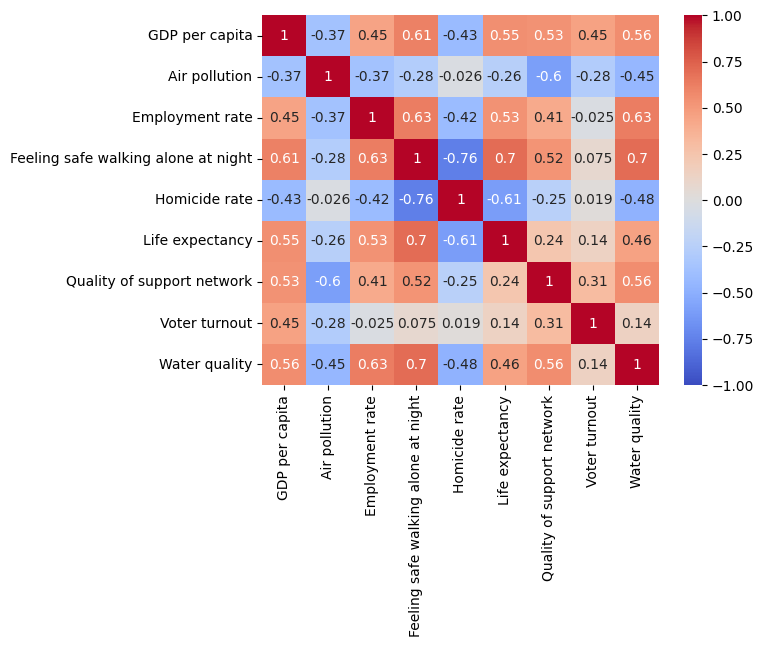

In [94]:
import seaborn as sns

sns.heatmap(
    train_set[feature_cols].corr(), 
    cmap="coolwarm", 
    annot=True, 
    vmin=-1, 
    vmax=1
);

plt.show()


## Let's do some fitting...

**New:** `Pipelines` support models as the last step!

- Very useful for setting up reproducible machine learning analyses!
- The `Pipeline` behaves just like a model, but it runs the transformations beforehand
- Simplifies the analysis: now we can just call the `.fit()` function of the pipeline instead of the model

Establish a baseline with a linear model:

In [95]:
# Linear model pipeline with two steps
linear_pipe = make_pipeline(StandardScaler(), LinearRegression())

# Fit the pipeline
# NEW: This applies all of the transformations, and then fits the model
print("Linear regression")
linear_pipe.fit(X_train, y_train)

# NEW: Print the training score
training_score = linear_pipe.score(X_train, y_train)
print(f"Training Score = {training_score}")

# NEW: Print the test score
test_score = linear_pipe.score(X_test, y_test)
print(f"Test Score = {test_score}")

Linear regression
Training Score = 0.7553332657461678
Test Score = 0.647886559044683


Now fit a random forest:

In [98]:
# Random forest model pipeline with two steps
forest_pipe = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, max_depth=2, random_state=42)
)

# Fit a random forest
print("Random forest")
forest_pipe.fit(X_train, y_train)

# Print the training score
training_score = forest_pipe.score(X_train, y_train)
print(f"Training Score = {training_score}")

# Print the test score
test_score = forest_pipe.score(X_test, y_test)
print(f"Test Score = {test_score}")

Random forest
Training Score = 0.8460559576380231
Test Score = 0.862756366860489


## Which variables matter the most?

Because random forests are an ensemble method with multiple estimators, the algorithm can learn which features help improve the fit the most.

- The *feature importances* are stored as the `feature_importances_` attribute
- Only available after calling `fit()`!

In [99]:
# What are the named steps?
forest_pipe.named_steps

{'standardscaler': StandardScaler(),
 'randomforestregressor': RandomForestRegressor(max_depth=2, random_state=42)}

In [100]:
# Get the forest model
forest_model = forest_pipe['randomforestregressor']

In [101]:
forest_model.feature_importances_

array([0.67746013, 0.0038663 , 0.13108609, 0.06579352, 0.00985913,
       0.01767323, 0.02635605, 0.00601776, 0.06188779])

In [102]:
# Make the dataframe
importance = pd.DataFrame(
    {"Feature": feature_cols, "Importance": forest_model.feature_importances_}
).sort_values("Importance", ascending=False)

In [103]:
importance

,Feature,Importance
0,GDP per capita,0.677460
2,Employment rate,0.131086
3,Feeling safe walking alone at night,0.065794
8,Water quality,0.061888
6,Quality of support network,0.026356
5,Life expectancy,0.017673
4,Homicide rate,0.009859
7,Voter turnout,0.006018
1,Air pollution,0.003866


In [104]:
# Plot
importance.sort_values("Importance", ascending=True).hvplot.barh(
    x="Feature", y="Importance", title="Does Money Make You Happier?"
)

/Users/delmelle/miniforge3/lib/python3.10/site-packages/holoviews/core/util.py:1010: RuntimeWarning: invalid value encountered in cast
  arr = np.array(values)
/Users/delmelle/miniforge3/lib/python3.10/site-packages/holoviews/core/util.py:1010: RuntimeWarning: invalid value encountered in cast
  arr = np.array(values)
/Users/delmelle/miniforge3/lib/python3.10/site-packages/holoviews/core/util.py:1010: RuntimeWarning: invalid value encountered in cast
  arr = np.array(values)
/Users/delmelle/miniforge3/lib/python3.10/site-packages/holoviews/core/util.py:1010: RuntimeWarning: invalid value encountered in cast
  arr = np.array(values)
/Users/delmelle/miniforge3/lib/python3.10/site-packages/holoviews/core/util.py:1010: RuntimeWarning: invalid value encountered in cast
  arr = np.array(values)
/Users/delmelle/miniforge3/lib/python3.10/site-packages/holoviews/core/util.py:1010: RuntimeWarning: invalid value encountered in cast
  arr = np.array(values)
/Users/delmelle/miniforge3/lib/python3.1

:Bars   [Feature]   (Importance)

## Let's improve our fitting with *k*-fold cross validation

1. Break the data into a training set and test set
1. Split the training set into *k* subsets (or folds), holding out one subset as the test set
1. Run the learning algorithm on each combination of subsets, using the average of all of the runs to find the best fitting model parameters

For more information, see the [scikit-learn docs](https://scikit-learn.org/stable/modules/cross_validation.html)



<img src="imgs/crossval.png" width=600></img>

The [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) function will automatically partition the training set into *k* folds, fit the model to the subset, and return the scores for each partition.

It takes a `Pipeline` object, the training features, and the training labels as arguments

In [26]:
from sklearn.model_selection import cross_val_score

## Let's do 3-fold cross validation

### Linear pipeline (baseline)

In [29]:
model = linear_pipe['linearregression']

In [30]:
# Make a linear pipeline
linear_pipe = make_pipeline(StandardScaler(), LinearRegression())

# Run the 3-fold cross validation
scores = cross_val_score(
    linear_pipe,
    X_train,
    y_train,
    cv=3,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [ 0.02064625 -0.84773581 -0.53652985]
Scores mean =  -0.4545398042994617
Score std dev =  0.35922474493059153


### Random forest model

In [31]:
# Make a random forest pipeline
forest_pipe = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 3-fold cross validation
scores = cross_val_score(
    forest_pipe,
    X_train,
    y_train,
    cv=3,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [0.5208505  0.78257711 0.66646144]
Scores mean =  0.6566296832385494
Score std dev =  0.1070753730357217


### Takeaway: the random forest model is clearly more accurate

## Question: Why did I choose to use 100 estimators in the RF model?

- In this case, I didn't have a good reason
- `n_estimators` is a model *hyperparameter*
- In practice, it's best to optimize the hyperparameters **and** the model parameters `(via the fit() method)`

**This is when cross validation becomes very important**

- Optimizing hyperparameters with a single train/test split means you are really optimizing based on your test set.
- If you use cross validation, a final test set will always be held in reserve to do a final evaluation.

### Enter GridSearchCV

A utility function that will:
- Iterate over a grid of hyperparameters
- Perform *k*-fold cross validation
- Return the parameter combination with the best overall score

[More info](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [122]:
from sklearn.model_selection import GridSearchCV

Let's do a search over the `n_estimators` parameter and the `max_depth` parameter:

In [123]:
# Create our regression pipeline
pipe = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

### Make the grid of parameters to search
 
- **NOTE:** you must prepend the name of the pipeline step
- The syntax for parameter names is:  "[step name]__[parameter name]"

In [124]:
pipe.named_steps

{'standardscaler': StandardScaler(),
 'randomforestregressor': RandomForestRegressor(random_state=42)}

In [125]:
model_step = "randomforestregressor"
param_grid = {
    f"{model_step}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_step}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51],
}

param_grid

{'randomforestregressor__n_estimators': [5, 10, 15, 20, 30, 50, 100, 200],
 'randomforestregressor__max_depth': [2, 5, 7, 9, 13, 21, 33, 51]}

In [126]:
# Create the grid and use 3-fold CV
grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)

# Run the search
grid.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [2, 5, 7, 9, 13,
                                                              21, 33, 51],
                         'randomforestregressor__n_estimators': [5, 10, 15, 20,
                                                                 30, 50, 100,
                                                                 200]},
             verbose=1)

In [38]:
# The best estimator
grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=7, random_state=42))])

In [127]:
# The best hyper parameters
grid.best_params_

{'randomforestregressor__max_depth': 7,
 'randomforestregressor__n_estimators': 100}

### Now let's evaluate!

We'll define a helper utility function to calculate the accuracy in terms of the mean absolute percent error

In [40]:
def evaluate_mape(model, X_test, y_test):
    """
    Given a model and test features/targets, print out the 
    mean absolute error and accuracy
    """
    # Make the predictions
    predictions = model.predict(X_test)

    # Absolute error
    errors = abs(predictions - y_test)
    avg_error = np.mean(errors)

    # Mean absolute percentage error
    mape = 100 * np.mean(errors / y_test)

    # Accuracy
    accuracy = 100 - mape

    print("Model Performance")
    print(f"Average Absolute Error: {avg_error:0.4f}")
    print(f"Accuracy = {accuracy:0.2f}%.")

    return accuracy

#### Linear model results

In [41]:
# Setup the pipeline
linear = make_pipeline(StandardScaler(), LinearRegression())

# Fit on train set
linear.fit(X_train, y_train)

# Evaluate on test set
evaluate_mape(linear, X_test, y_test)

Model Performance
Average Absolute Error: 0.3281
Accuracy = 94.93%.


94.92864894582036

#### Random forest results with default parameters

In [42]:
# Initialize the pipeline
base_model = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))

# Fit the training set
base_model.fit(X_train, y_train)

# Evaluate on the test set
base_accuracy = evaluate_mape(base_model, X_test, y_test)

Model Performance
Average Absolute Error: 0.2322
Accuracy = 96.43%.


#### The random forest model with the optimal hyperparameters

Small improvement!

In [43]:
grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=7, random_state=42))])

In [45]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
random_accuracy = evaluate_mape(best_random, X_test, y_test)

# What's the improvement?
improvement = 100 * (random_accuracy - base_accuracy) / base_accuracy
print(f'Improvement of {improvement:0.4f}%.')

Model Performance
Average Absolute Error: 0.2320
Accuracy = 96.43%.
Improvement of 0.0011%.


<h2 style="color: red;">Recap</h2>

- Decision trees and random forests
- Cross validation with `cross_val_score`
- Optimizing hyperparameters with `GridSearchCV`
- Feature importances from random forests

# Modeling residential sales in Philadelphia

In this part, we'll use a random forest model and housing data from the Office of Property Assessment to predict residential sale prices in Philadelphia

### Machine learning models are increasingly common in the real estate industry
  - [Airbnb recommends pricing to hosts](https://spectrum.ieee.org/computing/software/the-secret-of-airbnbs-pricing-algorithm)
  - [Trulia converts house photos to house features](https://www.trulia.com/blog/tech/image-recognition/)
  - [Zillow's Zestimate](https://www.zillow.com/research/zestimate-forecast-methodology/)

### The hedonic approach to housing prices

- An econometric approach
- Deconstruct housing price to the value of each of its parts
- Captures the "price premium" consumers are willing to pay for an extra bedroom or garage

### What contributes to the price of a house?

- Property characteristics, e.g, size of the lot and the number of bedrooms
- Neighborhood features based on amenities or disamenities, e.g., access to transit or exposure to crime
- Spatial component that captures the tendency of housing prices to depend on the prices of neighboring homes

**Note:** We'll focus on the first two components in this analysis

### Why are these kinds of models important?

- They are used widely by cities to perform property assessment valuation
    - Train a model on recent residential sales
    - Apply the model to the entire residential housing stock to produce assessments
- Biases in the algorithmic models have important consequences for city residents


**Too often, these models perpetuate inequality: low-value homes are over-assessed and high-value homes are under-assessed**

### Philadelphia's assessments are...not good

- [City Controller analysis of property assessments: Part 1](https://controller.phila.gov/philadelphia-audits/property-assessment-review/)
- [City Controller analysis of assessments: Part 2](https://controller.phila.gov/philadelphia-audits/opa-accuracy-2023/)
- [Urban Spatial paper on algorithmic fairness with a case study on modeling Philadelphia's home values](https://urbanspatial.github.io/AlgorithmicFairness_ACodebasedPrimerForPublicSectorDataScientists)


### Data from the Office of Property Assessment

Let's download data for properties in Philadelphia that had their last sale during 2022 (the last full calendar year)

Sources: 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

In [109]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# Only pull 2022 sales for single family residential properties
where = "sale_date >= '2022-01-01' and sale_date <= '2022-12-31'"
where = where + " and category_code_description IN ('SINGLE FAMILY', 'Single Family')"

In [116]:
# Create the query
query = f"SELECT * FROM opa_properties_public WHERE {where}"

# Make the request
params = {"q": query, "format": "geojson", "where": where}
response = requests.get(carto_url, params=params)

# Make the GeoDataFrame
salesRaw = gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")

In [118]:
salesRaw.head()

,geometry,cartodb_id,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,utility,view_type,year_built,year_built_estimate,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid
0,POINT (-75.18250 39.99616),1136,2024-06-06T16:04:59Z,None,57' N HUNTINGDON ST,54347360,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,None,I,1915,Y,19132,RSA5,1001384821,22,ROW TYPICAL,546106639
1,POINT (-75.11476 39.99888),3321,2024-06-06T16:08:59Z,D,15' N CORNWALL ST,54341670,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,None,I,1920,None,19134,RSA5,1001231917,24,ROW PORCH FRONT,546107480
2,POINT (-75.20713 39.95651),3597,2024-05-15T13:40:15Z,None,175'NW COR 42ND CHESTNUT,54323843,691,STACKED PUD 5+ STY MAS+OTH,1,SINGLE FAMILY,...,None,I,2017,None,19104,CMX4,1001140177,40,CONDO NON CONFORMING,546110639
3,POINT (-75.22952 40.03209),3917,2024-06-06T16:08:50Z,C,"85'3 7/8""E SMICK",54324208,H50,SEMI/DET 3 STY MASONRY,1,SINGLE FAMILY,...,None,I,1900,Y,19127,RSA5,1001273076,32,TWIN CONVENTIONAL,546110496
4,POINT (-75.22352 39.95894),4397,2024-06-06T16:11:17Z,None,90' W 51ST ST,54325718,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,None,I,1925,Y,19139,RSA6,1001439821,24,ROW PORCH FRONT,546110185


In [119]:
len(salesRaw)

25341

### The OPA is messy

**Lots** of missing data.

We can use the [missingno](https://github.com/ResidentMario/missingno) package to visualize the missing data easily.

In [128]:
# We'll visualize the first half of columns
# and then the second half
ncol = len(salesRaw.columns)

fields1 = salesRaw.columns[:ncol//2]
fields2 = salesRaw.columns[ncol//2:]

In [129]:
ncol

80

In [130]:
# The first half of columns
msno.bar(salesRaw[fields1]);

In [134]:
# The second half of columns
msno.bar(salesRaw[fields2]);

In [133]:
# The feature columns we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "zip_code",
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols].dropna()

# Trim zip code to only the first five digits
sales['zip_code'] = sales['zip_code'].astype(str).str.slice(0, 5)

In [60]:
len(sales)

23489

In [61]:
# Trim very low and very high sales
valid = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[valid]

In [62]:
len(sales)

17695

### Let's focus on numerical features only first

In [63]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels: log of sale price
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

# The features
feature_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

In [64]:
# Make a random forest pipeline
forest = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 10-fold cross validation
scores = cross_val_score(
    forest,
    X_train,
    y_train,
    cv=10,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [0.37576633 0.33345647 0.28397789 0.35228166 0.33129834 0.33313184
 0.30800545 0.35885686 0.31309565 0.30907434]
Scores mean =  0.3298944828897191
Score std dev =  0.0260240532104824


In [65]:
# Fit on the training data
forest.fit(X_train, y_train)

# What's the test score?
forest.score(X_test, y_test)

0.2937375087805091

### Which variables were most important?

In [66]:
# Extract the regressor from the pipeline
regressor = forest["randomforestregressor"]

In [67]:
# Create the data frame of importances
importance = pd.DataFrame(
    {
     "Feature": feature_cols, 
     "Importance": regressor.feature_importances_
    }
).sort_values(by="Importance")

importance.hvplot.barh(x="Feature", y="Importance")

:Bars   [Feature]   (Importance)

**Takeaway**: Number of bathrooms and area-based features still important